# Content

This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

**Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.

**Age**: Positive Integer variable of the reviewers age.

**Title**: String variable for the title of the review.

**Review Text**: String variable for the review body.

**Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

**Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

**Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.

**Division Name**: Categorical name of the product high level division.

**Department Name**: Categorical name of the product department name.

**Class Name**: Categorical name of the product class name.

![](https://c1.wallpaperflare.com/preview/191/476/40/fashion-clothing-shop-clothes.jpg)

The objective of our analysis today is to look through the reviews, determine if they are positive or negative (sentiment analysis) and find out what the customers like and dislike about the clothing. We will also find out what is the most popular and least popular items, as well as look at the distribution of the customers according to their age groups.

This will help us optimize the product and market strategy for this e-commerce store. Please upvote if you liked this notebook!

# Importing Libraries and Data

In [1]:
!pip install plotly
!pip install chart_studio
!pip install cufflinks
!pip install textblob

     |████████████████████████████████| 64 kB 310 kB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import plotly as py
import cufflinks as cf
from plotly.offline import iplot

In [4]:
py.offline.init_notebook_mode(connected=True)
cf.go_offline()

In [5]:
df = pd.read_csv("../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col=0)
df.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

Seems like "Clothing ID" and the "Title" is not that useful for us. So let's drop them from the dataset.

In [6]:
df.drop(["Clothing ID", "Title"], axis=1, inplace=True)
df.head()

Age                                        Review Text  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   60  I had such high hopes for this dress and reall...       3   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  
0  Intimates  
1    Dresses  
2    Dresses  
3      Pants  
4    Blouses

# Data Cleaning and Preparation

Let's check for missing values.

In [7]:
df.isnull().sum()

Age                          0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name               14
Department Name             14
Class Name                  14
dtype: int64

Since we will be working on Sentiment Analysis based on the "Review Text", there is no way for us to fill in the missing "Review Text" data. Let's drop it from the dataframe.

Additionally, it seems that the missing values for "Division Name", "Department Name" and "Class Name" is the same. Let's test that hypothesis by dropping null values for "Division Name".

In [8]:
df.dropna(subset=["Review Text", "Division Name"], inplace=True)

In [9]:
df.isnull().sum()

Age                        0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

Looks like our hypothesis is true. Next, let's convert our "Review Text" into one large corpus in the form of a list.

In [10]:
df["Review Text"].tolist()

['Absolutely wonderful - silky and sexy and comfortable',
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

Seems like there are many contractions in this corpus of text. Let's replace them in the next portion of our notebook.

# Text Cleaning

There are many ways to deal with contractions such as tokenization, stemming and lemmatization with different libraries (such as NLTK). But I will just use a modified version of the list of contractions from wikipedia (https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) for convenience sake.

In [11]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [12]:
def decontracted(x):
    if type(x) is str:
        x = x.replace('\\', '')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [13]:
df["Review Text"] = df["Review Text"].apply(lambda x: decontracted(x))

In [14]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We want to remove all punctuation except for fullstops, commas, and exclamation marks.

In [15]:
punctuation = '"#$%&\'()*+-/:;<=>?@[\\]^_`{|}~'
numbers = "0123456789"

def clean_text(text):
    clean_list = [x for x in text if x not in punctuation]
    clean_list = [x for x in clean_list if x not in numbers]
    clean_list = [x.lower() for x in clean_list]
    cleaned_text = ''.join(clean_list)
    return cleaned_text

In [16]:
df["Review Text"] = df["Review Text"].apply(clean_text)
df["Review Text"].tolist()

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress!  it is sooo pretty.  i happened to find it in a store, and im glad i did bc i never would have ordered it online bc it is petite.  i bought a petite and am .  i love the length on me hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small my usual size but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap net over layers. imo, a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love, love, love this jumpsuit. it is fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!',
 'this sh

Great. Now let's engineer some text features before moving on to data visualization.

# Feature Engineering

In [17]:
from textblob import TextBlob
df.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
2   60  i had such high hopes for this dress and reall...       3   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  
0  Intimates  
1    Dresses  
2    Dresses  
3      Pants  
4    Blouses

In [18]:
df["Polarity"] = df["Review Text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["Review Length"] = df["Review Text"].apply(lambda x: len(x))
df["Word Count"] = df["Review Text"].apply(lambda x: len(x.split()))

In [19]:
def average_word_length(x):
    words = x.split()
    word_length = 0
    for word in words:
        word_length += len(word)
        
    return word_length/len(words)

In [20]:
df["Average Word Length"] = df["Review Text"].apply(lambda x: average_word_length(x))

In [21]:
df.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
2   60  i had such high hopes for this dress and reall...       3   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Polarity  Review Length  Word Count  Average Word Length  
0  Intimates  0.633333             52           7             6.428571  
1    Dresses  0.339583            299          64             3.609375  
2    Dresses  0.073675            495          97             4.103093  
3      Pants  0.550000            125          23             4.478261  
4    Blouses  0.512891            192          36             4.361111

# Data Visualization

Let's first take a look at the distribution of sentiment polarity in this dataset. To be clear, a polarity of 1 is overwhelmingly positive, a polarity of -1 is overwhelmingly negative and a polarity of 0 is neutral. 

In [22]:
df["Polarity"].iplot(kind="hist", colors="blue", bins=50,
                    xTitle = "Sentiment Polarity",
                    yTitle = "Count",
                    title = "Sentiment Polarity Distribution")

We can see that there is a normal distribution centered around 0.175 polarity. Most of the reviews were positive, and a small fraction was negative. Now let's explore the distribution of review ratings (how good or bad were the reviews exactly?) and the reviewers age (do certain age groups tend to have a better opinion of our clothes?)

In [23]:
df["Age"].iplot(kind="hist", colors="red", bins=50,
                xTitle = "Age",
                yTitle = "Count",
                title = "Age Distribution",
                linecolor = 'black')

From this, we can tell that the median of our age groups is around 38 years old, with younger people constituting to a larger proportion of our customers. However, a sizeable amount of customers still come from age 40+.

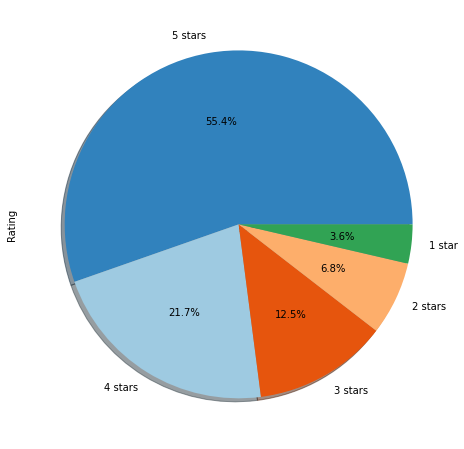

In [24]:
plt.figure(figsize=(8,8))
labels = ["5 stars", "4 stars", "3 stars", "2 stars", "1 star"]
cmap = plt.get_cmap("tab20c")
df["Rating"].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, labels=labels, colors = cmap(np.arange(5)*2))

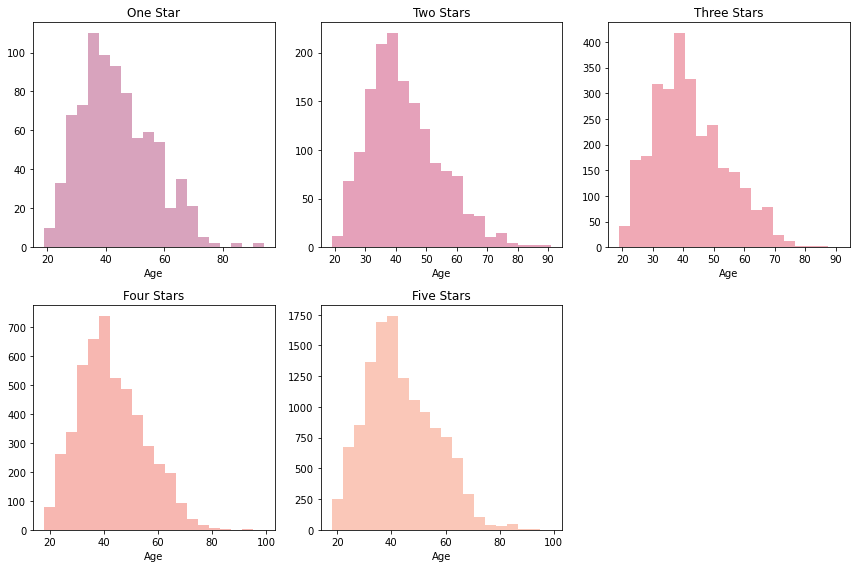

In [25]:
rocket = plt.get_cmap("rocket")
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12, 8))
one = df[df["Rating"] == 1]["Age"]
two = df[df["Rating"] == 2]["Age"]
three = df[df["Rating"] == 3]["Age"]
four = df[df["Rating"] == 4]["Age"]
five = df[df["Rating"] == 5]["Age"]

ax1 = sns.distplot(one, ax=axes[0][0], kde=False, bins=20, color=rocket(100))
ax1.set_title('One Star')

ax2 = sns.distplot(two, ax=axes[0][1], kde=False, bins=20, color=rocket(120))
ax2.set_title('Two Stars')

ax3 = sns.distplot(three, ax=axes[0][2], kde=False, bins=20, color=rocket(140))
ax3.set_title('Three Stars')

ax4 = sns.distplot(four, ax=axes[1][0], kde=False, bins=20, color=rocket(160))
ax4.set_title('Four Stars')

ax5 = sns.distplot(five, ax=axes[1][1], kde=False, bins=20, color=rocket(180))
ax5.set_title('Five Stars')

axes[-1, -1].axis("off")

plt.tight_layout()

Majority of our review is good, with over 77% 4/5 stars. It also seems that our reviews, regardless of positive or negative, is distributed similarly across age groups (i.e. no age group seem to favour our clothes more than others). 

# Analyzing Engineered Features

Next, we will look at the features we created. We have already analyzed the polarity, so let's focus on the review text length and word length.

In [26]:
df["Review Length"].iplot(kind="hist", colors="green",
                          xTitle = 'Review Length',
                          yTitle = "Count",
                          title = "Review Length Distribution")

We can see that most reviews have 500 or more characters. This can be a useful for sorting out authentic reviews from fake reviews (bots).

In [27]:
df["Word Count"].iplot(kind="hist", colors="#B6E880",
                          xTitle = 'Review Length',
                          yTitle = "Count",
                          title = "Review Length Distribution")

Seems like the length of reviews also tend towards the high side (94+ words). As most of our reviews are positive, we can infer that positive reviews are likely to be long and have many word/characters.

# Distribution of Department, Division and Class

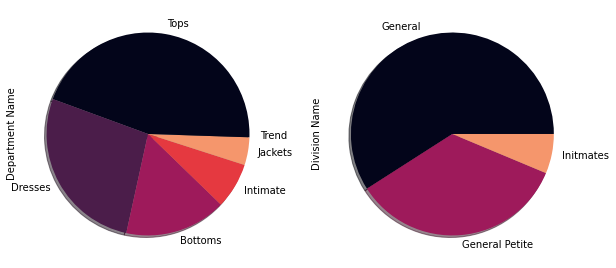

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))
ax=df["Department Name"].value_counts().plot.pie(ax = axes[0], shadow=True, colors=rocket(np.arange(5)*50))
ax1=df["Division Name"].value_counts().plot.pie(ax = axes[1], shadow=True, colors=rocket(np.arange(5)*100))

In [29]:
df["Class Name"].value_counts().iplot(kind="bar", colors='rgb(95, 70, 144)',
                                           xTitle = 'Class',
                                           yTitle = "Count",
                                           title = "Class Distribution")

From here, we can see that the most popular type of item are dresses, followed by an assortment of tops.

# Unigram, Bigram and Trigram Analysis

Let's first create a function that can read in a list of words and return us the top n number of words and their frequencies.

In [30]:
x = ["This is a list of words, which are words that are in a list."]

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer().fit(x)
bag_of_words = vectorizer.transform(x)
sum_of_words = bag_of_words.sum(axis=0)
word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
word_frequency

[('list', 2),
 ('words', 2),
 ('are', 2),
 ('this', 1),
 ('is', 1),
 ('of', 1),
 ('which', 1),
 ('that', 1),
 ('in', 1)]

And if we want the top 5 words:

In [32]:
word_frequency[:5]

[('list', 2), ('words', 2), ('are', 2), ('this', 1), ('is', 1)]

Great, now let's put this into a function.

In [33]:
def top_n_words(x, n):
    vectorizer = CountVectorizer().fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

Let's take a look at our top 20 words in the reviews.

In [34]:
top_n_words(df["Review Text"], 20)

[('the', 76053),
 ('it', 48995),
 ('and', 48903),
 ('is', 38128),
 ('this', 25720),
 ('to', 24440),
 ('in', 20608),
 ('not', 16964),
 ('but', 16508),
 ('on', 15200),
 ('for', 13993),
 ('of', 13420),
 ('was', 12921),
 ('with', 12787),
 ('so', 11966),
 ('my', 11024),
 ('dress', 10503),
 ('that', 10001),
 ('love', 8934),
 ('size', 8711)]

Let's take a look at the top 20 bigrams and trigrams too.

In [35]:
def top_n_bigrams(x, n):
    vectorizer = CountVectorizer(ngram_range=(2,2)).fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [36]:
top_n_bigrams(df["Review Text"], 20)

[('it is', 12468),
 ('in the', 7171),
 ('and the', 5615),
 ('this dress', 4732),
 ('on the', 4334),
 ('of the', 3932),
 ('and it', 3719),
 ('it was', 3280),
 ('this top', 2926),
 ('this is', 2762),
 ('is very', 2728),
 ('the fabric', 2642),
 ('love the', 2638),
 ('did not', 2484),
 ('love this', 2328),
 ('to wear', 2257),
 ('but it', 2185),
 ('the dress', 2179),
 ('is not', 2133),
 ('do not', 2115)]

In [37]:
def top_n_trigrams(x, n):
    vectorizer = CountVectorizer(ngram_range=(3,3)).fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [38]:
top_n_trigrams(df["Review Text"], 20)

[('the fabric is', 1297),
 ('true to size', 1281),
 ('and it is', 1122),
 ('this dress is', 1118),
 ('it is very', 971),
 ('but it is', 919),
 ('it is not', 905),
 ('the material is', 895),
 ('if you are', 733),
 ('in the store', 727),
 ('on the model', 721),
 ('the fit is', 697),
 ('this top is', 672),
 ('the color is', 630),
 ('love this dress', 598),
 ('it is so', 584),
 ('tried it on', 574),
 ('and it was', 549),
 ('in the back', 527),
 ('the dress is', 518)]

From here, we can see some useful key words such as "dress", "material", "fabric", and "color". But this is mostly not that useful as there are too many stopwords (commonly occuring words that have no context value, such as "this, it, the, is" etc). Let's remove the stopwords and see if our analysis turns up with something more useful.

In [39]:
def top_n_words(x, n):
    vectorizer = CountVectorizer(stop_words='english').fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [40]:
def top_n_bigrams(x, n):
    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [41]:
def top_n_trigrams(x, n):
    vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english').fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [42]:
top_unigrams = top_n_words(df["Review Text"], 20)
df_unigrams = pd.DataFrame(top_unigrams)
top_unigrams

[('dress', 10503),
 ('love', 8934),
 ('size', 8711),
 ('fit', 7278),
 ('like', 7005),
 ('wear', 6415),
 ('great', 6100),
 ('just', 5595),
 ('im', 5556),
 ('fabric', 4771),
 ('small', 4568),
 ('color', 4563),
 ('look', 4024),
 ('really', 3922),
 ('ordered', 3835),
 ('little', 3771),
 ('perfect', 3750),
 ('flattering', 3493),
 ('did', 3444),
 ('soft', 3310)]

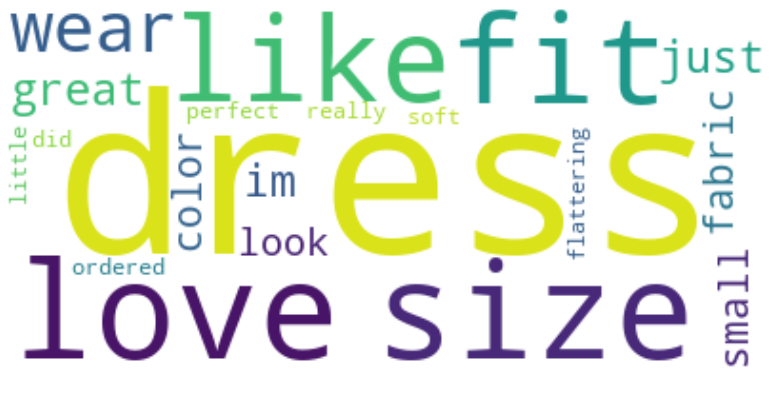

In [43]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(df_unigrams.set_index(0)[1])
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
top_bigrams = top_n_bigrams(df["Review Text"], 20)
df_bigrams = pd.DataFrame(top_bigrams)
top_bigrams

[('true size', 1312),
 ('love dress', 759),
 ('usually wear', 694),
 ('looks great', 619),
 ('fit perfectly', 606),
 ('im lbs', 538),
 ('size small', 534),
 ('fits perfectly', 486),
 ('usual size', 480),
 ('just right', 429),
 ('look like', 425),
 ('size fit', 376),
 ('ordered size', 375),
 ('love love', 370),
 ('looks like', 370),
 ('wear size', 365),
 ('highly recommend', 363),
 ('super cute', 361),
 ('runs large', 361),
 ('fabric soft', 355)]

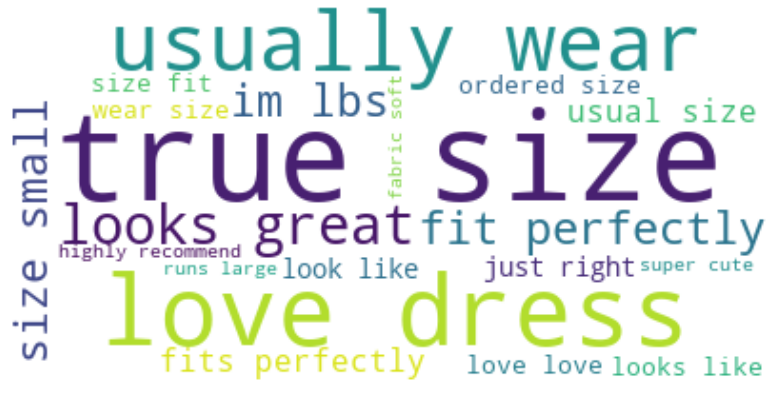

In [45]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(df_bigrams.set_index(0)[1])
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
top_trigrams = top_n_trigrams(df["Review Text"], 20)
df_trigrams = pd.DataFrame(top_trigrams)
top_trigrams

[('fits true size', 274),
 ('fit true size', 223),
 ('runs true size', 144),
 ('love love love', 142),
 ('usually wear size', 135),
 ('ordered usual size', 108),
 ('does run large', 96),
 ('really wanted love', 94),
 ('im glad did', 93),
 ('size fit perfectly', 93),
 ('wanted love dress', 87),
 ('usually wear small', 75),
 ('reference im lbs', 75),
 ('small fit perfectly', 73),
 ('just did work', 71),
 ('fit like glove', 69),
 ('size fits perfectly', 68),
 ('normally wear size', 68),
 ('looks great jeans', 68),
 ('usually wear medium', 67)]

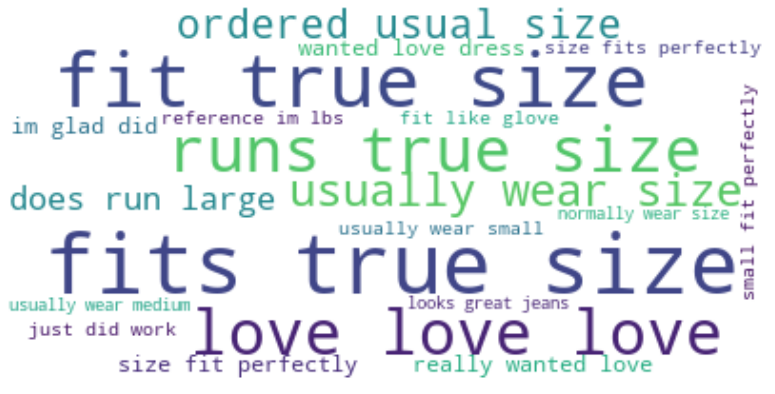

In [47]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(df_trigrams.set_index(0)[1])
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is much more useful. We can see that the dresses are very well liked, and many of the reviews praise the fitting of the clothes as well as the aesthetics.

# Building a Sentiment Classifier

Even though we can get a rough judgement on the polarity of reviews based on the TextBlob sentiment polarity function, let's create a classifier based on our own terms. For this purpose, I will classify reviews with 4 and 5 stars as positive reviews, 3 as neutral, and below 3 as negative. Let's reflect this in a new feature column.

In [48]:
positive = (df["Rating"] >= 4)
neutral = (df["Rating"] == 3)
negative = (df["Rating"] < 3)

df["Review Type"] = " "
df["Review Type"][positive] = "Positive"
df["Review Type"][neutral] = "Neutral"
df["Review Type"][negative] = "Negative"

df.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
2   60  i had such high hopes for this dress and reall...       3   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Polarity  Review Length  Word Count  Average Word Length  \
0  Intimates  0.633333             52           7             6.428571   
1    Dresses  0.339583            299          64             3.609375   
2    Dresses  0.073675            495          97             4.103093   
3      Pants  0.550000            125          23             4.478261   
4    Blouses  0.512891            192          36             4.361111   

  Review Type  
0    Positive  
1    Positive  
2     Neutral  
3    Positive  
4    Positive

Neat. Now let's map the Review Type from categorical data to numerical data. Positive = 1, Neutral = 0, and Negative = -1

In [49]:
review_type = {"Positive": 2, "Neutral": 1, "Negative": 0}
df["Review Type"] = df["Review Type"].map(review_type)

In [50]:
df.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
2   60  i had such high hopes for this dress and reall...       3   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Polarity  Review Length  Word Count  Average Word Length  \
0  Intimates  0.633333             52           7             6.428571   
1    Dresses  0.339583            299          64             3.609375   
2    Dresses  0.073675            495          97             4.103093   
3      Pants  0.550000            125          23             4.478261   
4    Blouses  0.512891            192          36             4.361111   

   Review Type  
0            2  
1            2  
2            1  
3            2  
4            2

In [51]:
X = df.iloc[:, 1].values
y = df.iloc[:, -1].values

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's use a unigram vectorizer with no stopwords filtered as a baseline.

In [53]:
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

Now, let's try one of the most well known classifiers for text data, Naive Bayes. But before that, we will create a dummy classifier that predicts the most frequent value as a benchmark.

In [54]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
    
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_vect, y_train)
y_dummy_predictions = dummy_majority.predict(X_test_vect)
print('Dummy Classifier Accuracy: {:.2f}'.format(accuracy_score(y_test, y_dummy_predictions)))

Dummy Classifier Accuracy: 0.78


Here we can see that even a classifier that just predicts the most frequent value ("Positive"/1) has an accuracy of 77%. This is due to the imbalanced nature of the dataset where most of the reviews are positive. Therefore, accuracy alone is not a reliable metric, and we have to take into account precision and recall as well.

![](https://miro.medium.com/max/1872/1*pOtBHai4jFd-ujaNXPilRg.png)

What exactly are accuracy, precision and recall? These are metrics to measure the performance of a predictive model. In essence:

1. Precision --> For all labels that were predicted positive by our algorithm, what % of them are actually positive? (i.e. We want an algorithm where not all true positive labels are predicted, but when it does predict a positive label, we can be confident that it's right.)

2. Recall --> For all labels that were predicted by our algorithm, if they were truly positive or classified wrongly as negative, what % of them are positive? (i.e. We want an algorithm that rarely fails to detect true positive labels, thereby minimizing false negatives.)

3. Accuracy --> For all labels, what % of them did our algorithm predict correctly?

Precision is important in customer-facing cases, where people tend to remember the failure of an algorithm even if it performs well most of the time. For example, a query suggestion in a web search interface.

Recall is especially important in the healthcare industry, where we want to be sure that if the AI predicts a tumor, it is actually a tumor.

In [55]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

MultinomialNB()

In [56]:
y_pred = classifier.predict(X_test_vect)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))

[[ 198  196  177]
 [  77  250  354]
 [  37  156 4212]]
Accuracy: 0.82
Precision: 0.65
Recall: 0.56


Seems like it didn't fare much better than the dummy classifier. The problem probably stems from the fact that we used a default unigram vectorizer. Let's tune the paramters a bit. We will tune the vectorizer to take into account unigrams and bigrams that only occur in 3 reviews or more.

In [57]:
vect = CountVectorizer(min_df=3, ngram_range=(1,2))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [58]:
classifier.fit(X_train_vect, y_train)
y_pred = classifier.predict(X_test_vect)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))

[[ 257  236   78]
 [ 113  366  202]
 [  49  292 4064]]
Accuracy: 0.83
Precision: 0.65
Recall: 0.64


Results improved, but only marginally. One likely cause is that neutral reviews have a mix of positive and negative sentiments, confusing the algorithm. In that case, let's focus on only the positive and negative reviews as they are generally more important.

# Modified Sentiment Analysis

In [59]:
df_modified = df[df["Review Type"] != 1]
df_modified.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   
5   49  i love tracy reese dresses, but this one is no...       2   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   
5                0                        4         General         Dresses   

  Class Name  Polarity  Review Length  Word Count  Average Word Length  \
0  Intimates  0.633333             52           7             6.428571   
1    Dresses  0.339583            299          64             3.609375   
3      Pants  0.550000            125          23             4.478261   
4    Blouses  0.512891            192          36             4.361111   
5    Dresses  0.178750            486          97             4.010309   

   Review Type  
0            2  
1            2  
3            2  
4            2  
5            0

In [60]:
X = df_modified.iloc[:, 1]
y = df_modified.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [61]:
vect = CountVectorizer(min_df=3, ngram_range=(1,2))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [62]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
    
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_vect, y_train)
y_dummy_predictions = dummy_majority.predict(X_test_vect)
print('Dummy Classifier Accuracy: {:.2f}'.format(accuracy_score(y_test, y_dummy_predictions)))

Dummy Classifier Accuracy: 0.88


![](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png)

If you realized, earlier I had already utilized a confusion matrix. However, I did not explain what it was as I used it for multi-class classification, which was unsuitable for this diagram (binary classification). That being said, once you understand the concept behind a confusion matrix, it is easy to extrapolate your interpretation to as many classes as you want.

1. Top left of the confusion matrix: True Positives --> Labels which the algorithm predicted as Positive and are actually Positive.

2. Top right of the confusion matrix: False Positives --> Labels which the algorithm predicted as Positive but are actually Negative.

3. Bottom left of the confusion matrix: False Negatives --> Labels which the algorithm predicted as Negatives but are actually Positive.

4. Bottom right of the confusion matrix: True Negatives --> Labels which the algorithm predicted as Negative and are actually Negative.

In this case, an ideal confusion matrix would be one where the values along the right diagonal (False Positives and False Negatives) are 0.

In [63]:
from sklearn.metrics import classification_report
classifier.fit(X_train_vect, y_train)
y_pred = classifier.predict(X_test_vect)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 480  102]
 [ 184 4186]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       582
           2       0.98      0.96      0.97      4370

    accuracy                           0.94      4952
   macro avg       0.85      0.89      0.87      4952
weighted avg       0.95      0.94      0.94      4952



In [64]:
val = ["The dress I ordered looked good online, but disappointing when I received it. Material is not bad but design needs improvement.", 
       "I had read bad reviews about their satin underwear, but it turned out to be great! Happy with my purchase."]
classifier.predict(vect.transform(val))

array([0, 2])

Great! Now we can be sure that any new review can be classified with a 94% accuracy. Let's dive deeper into the positive and negative reviews.

# Positive/Negative Review Analysis

In [65]:
reverse_map = {2: "Positive", 0: "Negative"}
df_modified["Review Type"] = df_modified["Review Type"].map(reverse_map)
df_modified.head()

Age                                        Review Text  Rating  \
0   33  absolutely wonderful  silky and sexy and comfo...       4   
1   34  love this dress!  it is sooo pretty.  i happen...       5   
3   50  i love, love, love this jumpsuit. it is fun, f...       5   
4   47  this shirt is very flattering to all due to th...       5   
5   49  i love tracy reese dresses, but this one is no...       2   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   
5                0                        4         General         Dresses   

  Class Name  Polarity  Review Length  Word Count  Average Word Length  \
0  Intimates  0.633333             52           7             6.428571   
1    Dresses  0.339583            299          64             3.609375   
3      Pants  0.550000            125          23             4.478261   
4    Blouses  0.512891            192          36             4.361111   
5    Dresses  0.178750            486          97             4.010309   

  Review Type  
0    Positive  
1    Positive  
3    Positive  
4    Positive  
5    Negative

In [66]:
df_positive = df_modified[df_modified["Review Type"] == "Positive"]
df_negative = df_modified[df_modified["Review Type"] == "Negative"]

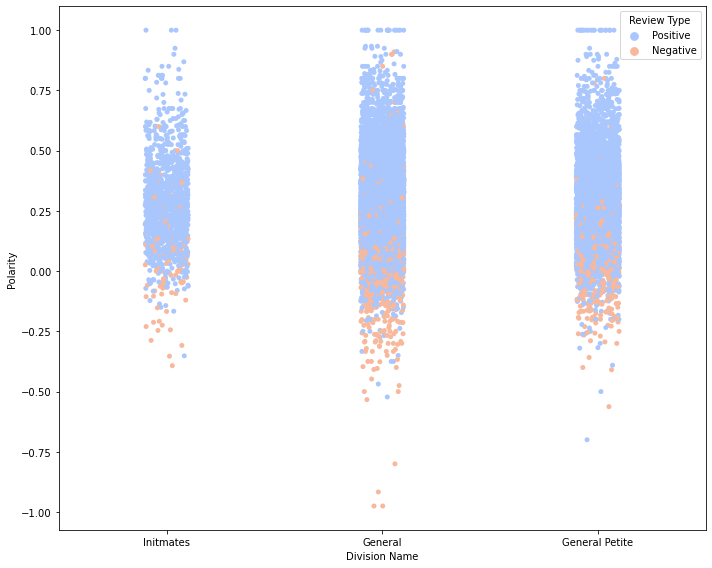

In [67]:
plt.figure(figsize=(10, 8))
sns.stripplot(x="Division Name", y="Polarity", data=df_modified, palette='coolwarm', hue='Review Type')
plt.tight_layout()

This makes sense, positive reviews tend to have greater polarity than negative reviews. However, it seems like there are more polarized negative reviews in the General Division as well as General Petite Division. This is possibly because there is a larger sample size in those two divisions.

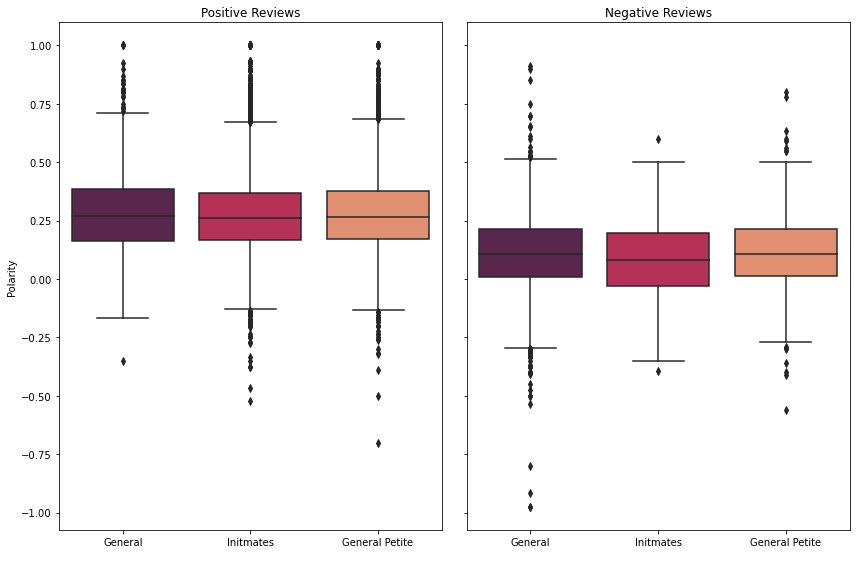

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 8), sharex=True, sharey=True)
ax = sns.boxplot(x="Division Name", y="Polarity", data=df_positive, ax=axes[0], palette='rocket')
ax.set_title("Positive Reviews")
ax.set_xlabel(" ")

ax1 = sns.boxplot(x="Division Name", y="Polarity", data=df_negative, ax=axes[1], palette='rocket')
ax1.set_title("Negative Reviews")
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.tight_layout()

Looking at the positive reviews, it seems that each Division performs almost equally well. The General Division performs minimally better with higher quartiles and less outliers with negative polarity. On the other hand, the Initmate Division seems to perform worse than the others in terms of negative reviews. It clearly has lower quartiles and with few outliers to offset this observation. Thus, we can be sure in our conclusion.

Let's do the same for Departments.

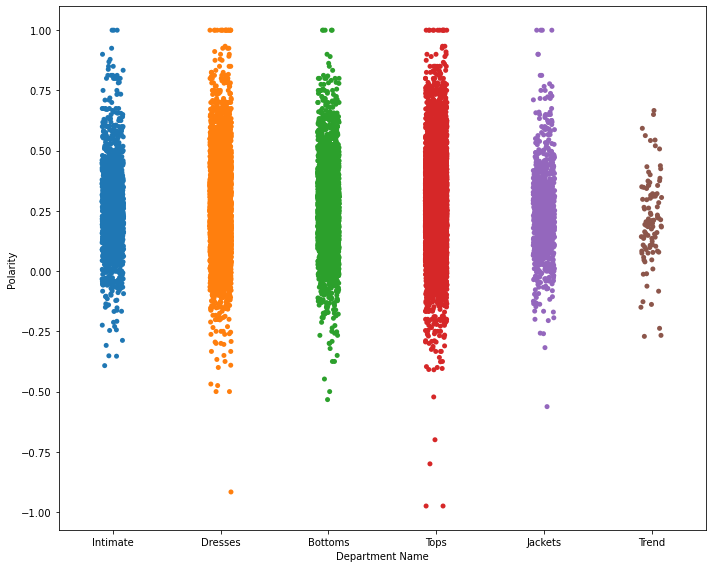

In [69]:
plt.figure(figsize=(10, 8))
sns.stripplot(x="Department Name", y="Polarity", data=df_modified)
plt.tight_layout()

A recap that Tops and Dresses occupy the majority of reviews here, followed closely by bottoms. It seems they are distributed quite similarly. However, there is an apparent trend that as the number of reviews increase, the number of polarizing reviews (more positive and more negative) reviews increase too.

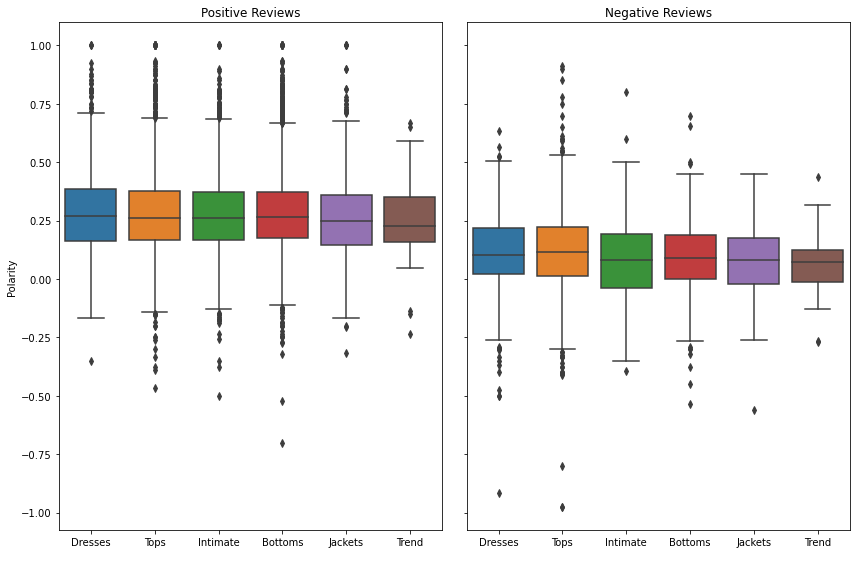

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 8), sharex=True, sharey=True)
ax = sns.boxplot(x="Department Name", y="Polarity", data=df_positive, ax=axes[0])
ax.set_title("Positive Reviews")
ax.set_xlabel(" ")

ax1 = sns.boxplot(x="Department Name", y="Polarity", data=df_negative, ax=axes[1])
ax1.set_title("Negative Reviews")
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.tight_layout()

In terms of positive reviews, most departments score the same except for Jackets and Trend. They are also the departments with the least number of reviews, so this is unsurprising. In terms of negative reviews, we can see that the Intimate department attracts more negative reviews than the others, with lower quartiles compared to others, which is unexpected.

Finally, we will take a look at the 20 most occuring words for positive and negative reviews. However, we will only want to look at nouns and adjectives, so we will use the Natural Language Tool Kit (NLTK) library to help us do this. Additionally, we will impose an additional filter that requires positive reviews to have a polarity of >= 0.25 and negative reviews to have a polarity of <0.

In [71]:
import nltk
df_positive = df_positive[df_positive["Polarity"] >= 0.25]
df_negative = df_negative[df_negative["Polarity"] < 0]

In [72]:
positive_words = []
for word in df_positive["Review Text"]:
    sen = nltk.word_tokenize(word)
    postag = nltk.pos_tag(sen)
    for postag in postag:
        if postag[1] == 'NN':
            positive_words.append(postag[0])
        elif postag[1] == 'NNP':
            positive_words.append(postag[0])
        elif postag[1] == 'JJ':
            positive_words.append(postag[0])
        elif postag[1] == 'JJR':
            positive_words.append(postag[0])
        elif postag[1] == 'JJS':
            positive_words.append(postag[0])

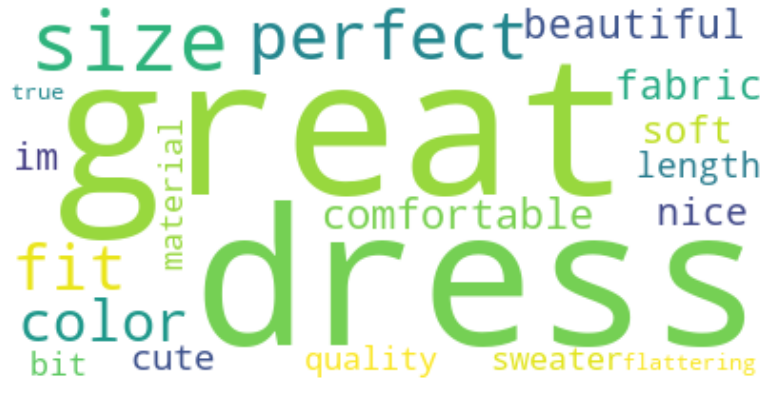

In [73]:
positive_unigrams = top_n_words(positive_words, 20)
df_unigrams = pd.DataFrame(positive_unigrams)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(df_unigrams.set_index(0)[1])
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From here, we are able to identify several key features of the clothes which customers liked. For example, the quality/material of the clothes.. How soft and comfortable the clothes are.. The fabric and color etc.

In [74]:
negative_words = []
for word in df_negative["Review Text"]:
    sen = nltk.word_tokenize(word)
    postag = nltk.pos_tag(sen)
    for postag in postag:
        if postag[1] == 'NN':
            negative_words.append(postag[0])
        elif postag[1] == 'NNP':
            negative_words.append(postag[0])
        elif postag[1] == 'JJ':
            negative_words.append(postag[0])
        elif postag[1] == 'JJR':
            negative_words.append(postag[0])
        elif postag[1] == 'JJS':
            negative_words.append(postag[0])

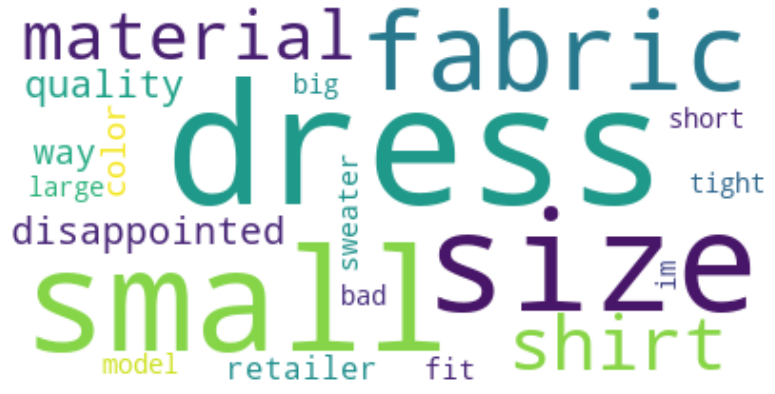

In [75]:
negative_unigrams = top_n_words(negative_words, 20)
df_unigrams = pd.DataFrame(negative_unigrams)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(df_unigrams.set_index(0)[1])
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like the most common complaint revolves around the size and fitting of the clothes. Sometimes it's too big, sometimes it's too small. It doesn't look like it does on the model, and it's too short etc.

# Miscellaneous Features Analysis

In this final section, we will analyze the rest of the features we have not yet gone through. Let's start with the "Recommended IND" (whether customers recommended the product or not).

In [76]:
import plotly.express as px
import plotly.graph_objects as go

In [77]:
recommended = df[df["Recommended IND"] == 1]
not_recommended = df[df["Recommended IND"] == 0]

In [78]:
recommended_graph = go.Histogram(x=recommended["Polarity"], name="Recommended", opacity=0.8)
not_recommended_graph = go.Histogram(x=not_recommended["Polarity"], name="Not Recommended", opacity=0.8)

In [79]:
data = [recommended_graph, not_recommended_graph]
layout = go.Layout(barmode="overlay", title = "Distribution of Polarity based on Recommendations Ind")
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Sentiment Polarity",
    yaxis_title="Count")
iplot(fig)

OK, so this is quite consistent with our findings. Better Sentiment Polarity equates to higher ratings and more recommendations. Let's see how recommendations are related to review ratings next.

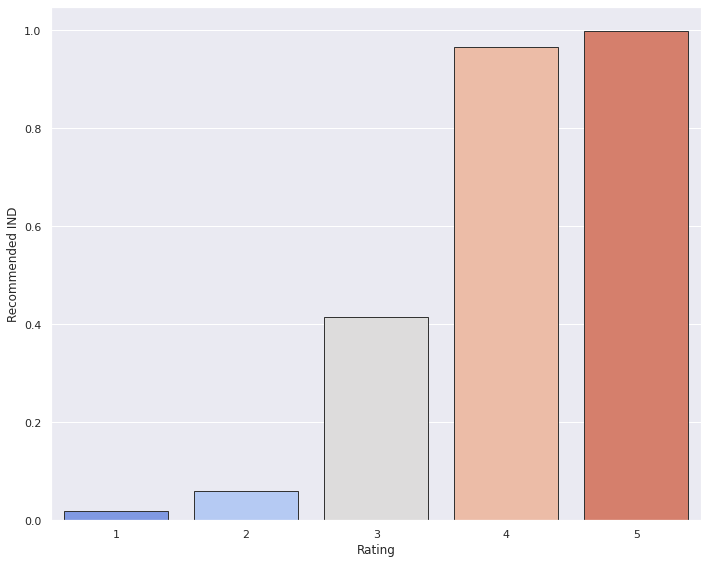

In [80]:
sns.set()
plt.figure(figsize=(10, 8))
sns.barplot(x="Rating", y="Recommended IND", data=df, palette="coolwarm", edgecolor=".2", ci=None)
plt.tight_layout()

Unsurprisingly, higher ratings lead to more instances of the product being recommended. However, there are still some products that have low rating yet are still recommended. Let's explore some of these reviews.

In [81]:
recommended[recommended["Rating"] < 3]["Review Text"].tolist()[:3]

['i got this top to wear with shorts as the color goes with a lot of different prints. the quality is excellent. this top runs very large, as in three  sizes too large. for the record i am a .. and ordered my regular size the xs and this top makes me like im pregnant with twins. also, the layering looks nothing like it does on the model, it looks sloppy, unkept and a general. i think this would still be great for ladies who are bigger in the chest and waist, otherwise it just does not wor',
 'is not a place i want to be, even if the style of a sweater is great.  yes, this sweater is very cropped, but i think itamps definitely intended to be worn off the shoulder to drop the waist a bit.  itamps the itchiness that makes it an immediate ampquotnoampquot, and thatamps coming from someone who has serious fiber itch tolerance.',
 'i loved this dress when i saw it. however the fit was way off. i am   lbs and the small was way too big from the waist down. when the xs arrived i was sure it wou

It's clear that some of these reviews are contradictory, which makes it difficult for our sentiment classifier to predict accurately. Let's remove them from the dataset. We will set a filter that if a review has a rating of 4 or more, it has to be recommended. If a review has a rating of less than 3, it cannot be recommended.

In [82]:
filtered = ((df_modified["Rating"] >= 4) & (df_modified["Recommended IND"] == 1)) | ((df_modified["Rating"] < 3) & (df_modified["Recommended IND"] == 0))
df_filtered = df_modified[filtered]

Let's use the filtered data to optimize the performance of our Sentiment Classifier.

In [83]:
X = df_filtered.iloc[:, 1]
y = df_filtered.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [84]:
vect = CountVectorizer(min_df=3, ngram_range=(1,2))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [85]:
from sklearn.metrics import classification_report
classifier.fit(X_train_vect, y_train)
y_pred = classifier.predict(X_test_vect)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 471  107]
 [ 148 4152]]
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.79       578
    Positive       0.97      0.97      0.97      4300

    accuracy                           0.95      4878
   macro avg       0.87      0.89      0.88      4878
weighted avg       0.95      0.95      0.95      4878



In [86]:
test = ['i got this top to wear with shorts as the color goes with a lot of different prints. the quality is excellent. this top runs very large, as in three  sizes too large.',
 'i loved this dress when i saw it. however the fit was way off. i am   lbs and the small was way too big from the waist down. when the xs arrived i was sure it would be perfect. unfortunately the waist hit way too high, above my rib cage and the dress was too short. it was as if it was a petite size. i was very disappointed as this is such a pretty, easy dress to just throw on for school. unfortunately neither size looked right on me and i had to return both.']
classifier.predict(vect.transform(test))

array(['Positive', 'Negative'], dtype='<U8')

Now, there are two ways we can optimize our Sentiment Classifier even further: by increasing Precision or by increasing Recall of our "Negative" review predictions. Remember, we will want a higher value of Precision if we want to be sure that when the classifier predicts a "Negative" review, it is actually a "Negative" review. We will want a higher value of Recall if we want the classifier to identify more "Negative" reviews correctly. 

However, there is always something to keep in mind: the precision-recall tradeoff. If we optimize one value, the other other value will inevitably drop. That is, there is no way to increase both precision and recall at the same time past a certain value. You can see this phenomena in the diagram below.

![](https://bbsmax.ikafan.com/static/L3Byb3h5L2h0dHBzL2ltZzIwMTguY25ibG9ncy5jb20vYmxvZy8xMDEyNTkwLzIwMTkwMy8xMDEyNTkwLTIwMTkwMzI3MTIyMTEwNjE4LTk5MzY2Nzg4OS5wbmc=.jpg)

As you can see, our algorithm is quite balanced with a Precision of 76% and a Recall of 80% for "Negative" review predictions. To optimize Precision or Recall any further will lead to skewed values. This is demonstrated below.

First, we will make use of a neat process known as Random Oversampling. This process duplicates the "Negative" reviews in our dataset randomly until the number of "Negative reviews" is the same as the number of "Positive Reviews". The rationale behind this is that an imbalanced dataset might lead to poorer predictive performance. Hence, equalizing the dataset might improve performance.

![](https://miro.medium.com/max/2246/1*o_KfyMzF7LITK2DlYm_wHw.png)

In [87]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer(min_df=3, ngram_range=(1,2))),
                     ('ROS', RandomOverSampler()),
                     ('clf', MultinomialNB())])

text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 494   84]
 [ 191 4109]]
              precision    recall  f1-score   support

    Negative       0.72      0.85      0.78       578
    Positive       0.98      0.96      0.97      4300

    accuracy                           0.94      4878
   macro avg       0.85      0.91      0.87      4878
weighted avg       0.95      0.94      0.95      4878



In [88]:
from sklearn.neural_network import MLPClassifier
text_clf = Pipeline([('vect', CountVectorizer(min_df=3, ngram_range=(1,2))),
                     ('ROS', RandomOverSampler()),
                     ('clf', MLPClassifier((100,3), verbose=3, early_stopping=True))])
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

Iteration 1, loss = 0.20497854
Validation score: 0.990734
Iteration 2, loss = 0.01759952
Validation score: 0.993050
Iteration 3, loss = 0.00497538
Validation score: 0.991120
Iteration 4, loss = 0.00226882
Validation score: 0.990734
Iteration 5, loss = 0.00137395
Validation score: 0.990734
Iteration 6, loss = 0.00097869
Validation score: 0.990734
Iteration 7, loss = 0.00075967
Validation score: 0.990734
Iteration 8, loss = 0.00062541
Validation score: 0.990734
Iteration 9, loss = 0.00053664
Validation score: 0.990734
Iteration 10, loss = 0.00047430
Validation score: 0.990734
Iteration 11, loss = 0.00042844
Validation score: 0.990734
Iteration 12, loss = 0.00039401
Validation score: 0.990734
Iteration 13, loss = 0.00036654
Validation score: 0.990734
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [89]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 341  237]
 [  55 4245]]
              precision    recall  f1-score   support

    Negative       0.86      0.59      0.70       578
    Positive       0.95      0.99      0.97      4300

    accuracy                           0.94      4878
   macro avg       0.90      0.79      0.83      4878
weighted avg       0.94      0.94      0.94      4878



As you can see, for both models, when the either precision or recall increase, the other decreased. That's it! Thanks for reading through this notebook and don't forget to upvote if you liked it!